In [42]:
#basically same as 20_Largest.py, but now instead of studying pairs of transfer endpoints, look at individual sites(both as sources and destinations)

#find the site with the highest number of transfers in an arbitrary time period (say two weeks), look at how various variables change over time. Rate of transfer failure rate for example.



In [43]:
#dependencies
print("Import Packages")

#Elasticsearch
from elasticsearch import Elasticsearch
#matplotlib.rc('font', **{'size': 15})
from elasticsearch.helpers import scan

#Time
import time
from datetime import datetime
import pytz #timezones

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#sorting dicts
import operator

print("Done")

Import Packages
Done


In [44]:
#define variables
print("Define Variables")
#millis*seconds*minutes*hours*days*weeks
interval = 1000*60*60 #plotting granularity
twoweeks = 1000*60*60*24#*7#*2

pattern = '%Y-%m-%d %H:%M:%S'
#pytz.timezone('America/Chicago')                                           
now_datetime = datetime.now().strftime(pattern)
now = int(time.time() * 1000 + 18000000) #add 5 hour difference from chicago to UTC
past = now - twoweeks

print(past, now)

#print(datetime.now())
#print(datetime.now(pytz.timezone('Europe/Oslo')))
print("Done")

Define Variables
1501513357895 1501599757895
Done


In [45]:
print("Connecting to chicago kibana")
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60) 

print("Defining Queries")
#define queries
query_done = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                }
            }
        },
            {"term": {"_type": "transfer-done"}},
            {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }

query_failed = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                 }
            }
        },
            {"term": {"_type": "transfer-failed"}},
            {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }
    
#make "scrolls"

#cern index
#my_index = "atlas_rucio-events*"

#chicago index
my_index = "rucio-events-2017*"


print("Performing Query")
scroll_done = scan(es, query=query_done, index=my_index, scroll='5m', timeout="5m", size=100)
scroll_errors = scan(es, query=query_failed, index=my_index, scroll='5m', timeout="5m", size=100)
print("Done")

Connecting to chicago kibana
Defining Queries
Performing Query
Done


In [46]:
#loop over scrolls

transfers_source = {}
transfers_dest = {}
failures_source = {}
failures_dest = {}

print("Looping over successful transfers")
count = 0
for entry in scroll_done:
    if not count%100000:  print("Processing event number ",count)
    count += 1
    source = entry['_source']['payload']['src-rse']
    destination = entry['_source']['payload']['dst-rse']
    transfertime = entry['_source']['payload']['transferred_at']
    #convert transfertime to epoch milliseconds
    transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
    if source not in transfers_source.keys():
        transfers_source[source] = []
    else:
        transfers_source[source].append(transfertime)
    
    if destination not in transfers_dest.keys():
        transfers_dest[destination] = []
    else:
        transfers_dest[destination].append(transfertime)
    
 
#print(transfers_source)   

print("Looping over failed transfers")
count = 0
for entry in scroll_errors:
    if not count%100000:  print("Processing event number ",count)
    count += 1
    source = entry['_source']['payload']['src-rse']
    destination = entry['_source']['payload']['dst-rse']
    transfertime = entry['_source']['payload']['transferred_at']
    #convert transfertime to epoch milliseconds
    transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
    if source not in failures_source.keys():
        failures_source[source] = []
    else:
        failures_source[source].append(transfertime)
    
    if destination not in failures_dest.keys():
        failures_dest[destination] = []
    else:
        failures_dest[destination].append(transfertime)
    
    
for entry in transfers_source:
    if entry not in failures_source.keys():
        failures_source[entry] = []
for entry in transfers_dest:
    if entry not in failures_dest.keys():
        failures_dest[entry] = []
for entry in failures_source:
    if entry not in transfers_source.keys():
        transfers_source[entry] = []
for entry in failures_dest:
    if entry not in transfers_dest.keys():
        transfers_dest[entry] = []
        
        
print("Done")

Looping over successful transfers
Processing event number  0
Processing event number  100000
Looping over failed transfers
Processing event number  0
Done


In [47]:
print("Finding most popluar site")

largest_trans_source = []
largest_trans_source_err = []
largest_trans_source_name = "name"
largest_trans_dest =  []
largest_trans_dest_err = []
largest_trans_dest_name = "name"
largest_error_source = []
largest_error_source_name = "name"
largest_error_dest = []
largest_error_dest_name = "name"

largest = 0
for entry in transfers_source:
    if len(transfers_source[entry]) > largest:
        largest_trans_source = transfers_source[entry]
        largest_trans_source_err = failures_source[entry]
        largest_trans_source_name = entry
        largest = len(transfers_source[entry])

largest = 0
for entry in transfers_dest:
    if len(transfers_dest[entry]) > largest:
        largest_trans_dest = transfers_dest[entry]
        largest_trans_dest_err = failures_dest[entry]
        largest_trans_dest_name = entry
        largest = len(transfers_dest[entry])

largest = 0
for entry in failures_source:
    if len(failures_source[entry]) > largest:
        largest_error_source = failures_source[entry]
        largest_error_source_name = entry
        largest = len(failures_source[entry])

largest = 0
for entry in failures_dest:
    if len(failures_dest[entry]) > largest:
        largest_error_dest = failures_dest[entry]
        largest_error_dest_name = entry
        largest = len(failures_dest[entry])

print("Done")

Finding most popluar site
Done


In [48]:
print("Sorting into time intervals")

sorted_trans_source = []
sorted_trans_dest = []
sorted_trans_source_err = []
sorted_trans_dest_err = []
sorted_error_source = []
sorted_error_dest = []
sorted_rate_source = []
sorted_rate_dest = []


timekeeper = past
while timekeeper <= now:
    
    bookkeeper_trans_source = 0
    bookkeeper_trans_dest = 0
    bookkeeper_trans_source_err = 0
    bookkeeper_trans_dest_err = 0
    bookkeeper_error_source = 0
    bookkeeper_error_dest = 0
    
    for timestamp in largest_trans_source:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_trans_source += 1
    sorted_trans_source.append(bookkeeper_trans_source)
    
    for timestamp in largest_trans_dest:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_trans_dest += 1
    sorted_trans_dest.append(bookkeeper_trans_dest)
    
    #failed transfer at sites with most successful transfer. Used to calculate transfer failure rate of these sites
    for timestamp in largest_trans_source_err:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_trans_source_err += 1
    sorted_trans_source_err.append(bookkeeper_trans_source_err)
    
    for timestamp in largest_trans_dest_err:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_trans_dest_err += 1
    sorted_trans_dest_err.append(bookkeeper_trans_dest_err)
    
    
    for timestamp in largest_error_source:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_error_source += 1
    sorted_error_source.append(bookkeeper_error_source)
    
    for timestamp in largest_error_dest:
        if timestamp > timekeeper and timestamp <= (timekeeper + interval):
            bookkeeper_error_dest += 1
    sorted_error_dest.append(bookkeeper_error_dest)
    
    if bookkeeper_trans_source == 0 and bookkeeper_trans_source_err == 0:
        sorted_rate_source.append(0.)
    else:
        sorted_rate_source.append(bookkeeper_trans_source_err/(bookkeeper_trans_source_err + bookkeeper_trans_source))
    
    if bookkeeper_trans_dest == 0 and bookkeeper_trans_dest_err == 0:
        sorted_rate_dest.append(0.)
    else:
        sorted_rate_dest.append(bookkeeper_trans_dest_err/(bookkeeper_trans_dest_err + bookkeeper_trans_dest))
    
    timekeeper += interval #IMPORTANT. Increase time interval to avoid eternal loop
    if (100 - int(100*(now-timekeeper)/(now-past))) % 10 == 0: 
        print("progress: %s %%" %(100 - int(100*(now-timekeeper)/(now-past))))
    

print("Done")

Sorting into time intervals
progress: 30 %
progress: 50 %
progress: 80 %
progress: 100 %
Done


Plotting
Largest source of successful transfers:  UKI-LT2-RHUL_DATADISK


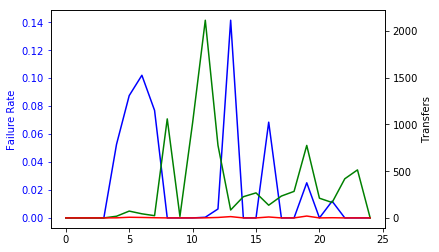

Largest recipient of successful transfers:  CERN-PROD_DATADISK


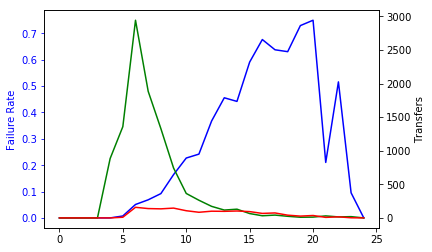

Largest source of failed transfers:  SFU-LCG2_DATADISK


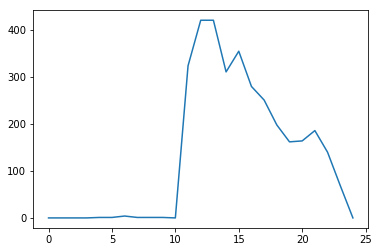

Largest recipient of failed transfers:  CERN-PROD_DATADISK


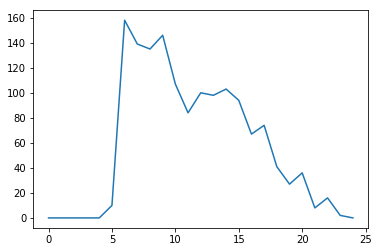

Done


In [50]:
print("Plotting")



print("Largest source of successful transfers: ", largest_trans_source_name)

fig, ax = plt.subplots()

# Twin the x-axis to make independent y-axes.
axes = [ax, ax.twinx()]
    
axes[0].plot(sorted_rate_source, color='Blue')
axes[0].set_ylabel('Failure Rate', color='Blue')
axes[0].tick_params(axis='y', colors='Blue')
    
axes[1].plot(sorted_trans_source,color='Green')
axes[1].set_ylabel('Transfers', color='Black')
axes[1].tick_params(axis='y', colors='Black')
    
axes[1].plot(sorted_trans_source_err,color='Red')


    
plt.show()

#plt.plot(sorted_trans_source)
#plt.show()

print("Largest recipient of successful transfers: ", largest_trans_dest_name)
fig, ax = plt.subplots()

# Twin the x-axis to make independent y-axes.
axes = [ax, ax.twinx()]
    
axes[0].plot(sorted_rate_dest, color='Blue')
axes[0].set_ylabel('Failure Rate', color='Blue')
axes[0].tick_params(axis='y', colors='Blue')
    
axes[1].plot(sorted_trans_dest,color='Green')
axes[1].set_ylabel('Transfers', color='Black')
axes[1].tick_params(axis='y', colors='Black')
    
axes[1].plot(sorted_trans_dest_err,color='Red')
    
plt.show()




#plt.plot(sorted_trans_dest)
#plt.show()

print("Largest source of failed transfers: ", largest_error_source_name)
plt.plot(sorted_error_source)
plt.show()

print("Largest recipient of failed transfers: ", largest_error_dest_name)
plt.plot(sorted_error_dest)
plt.show()

print("Done")